# Лабораторная работа № 6
## по дисциплине "Теория систем"
Чайкин В. К., P3324

Установка и импорт библиотек

In [171]:
!pip install numpy Pillow


[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Импорт библиотек

In [172]:
import numpy as np
from PIL import Image
from typing import Callable
import random

In [173]:
wolfram_code = 90
width = 256
height = 256
display_scale_factor = 2
colored_pixel_indices = [width // 2 + 1]

Функции для форматирования и конвертации

In [174]:
def format_bin(num: int, digit_count=8) -> str:
    result = (
        bin(num & ((1 << digit_count) - 1))
        .lstrip('0b')
        .zfill(digit_count)
    )
    return result

def to_list_bool(num: int, bit_count: 8) -> list[bool]:
    masked = num & ((1 << bit_count) - 1)
    result_arr = []
    
    for i in range(bit_count):
        j = bit_count - 1 - i
        selected_bit = (masked >> j) & 1
        result_arr.append(selected_bit != 0)
    
    return result_arr

def from_list_bool(bools: list[bool], bit_count: int = None) -> int:
    if bit_count is None:
        bit_count = len(bools)
    result = 0
    
    for i in range(bit_count):
        result <<= 1
        result |= bools[i]
        
    return result

assert format_bin(0b111, 4) == '0111'
assert to_list_bool(0b111, 4) == [False, True, True, True]
assert from_list_bool([False, True, True, True], 4) == 0b111

Генерация булевой функции из кода Вольфрама

In [175]:
print(f"Wolfram Code: {wolfram_code} = {format_bin(wolfram_code)}")

def bool_func_from_wolfram_code(code, slot_count=3) -> Callable[[list[bool]], bool]:
    masked = code & (1 << (1 << slot_count)) - 1  # There exist 2 ** n current_states and 2 ** (2 ** n) rules
    print(f"Masked code: {masked} = {format_bin(masked)}")
    
    for i in range(1 << slot_count):
        selected_digit = (masked >> i) & 1
        print(f"{format_bin(i, digit_count=3)}: {selected_digit}")
        
    def func(inputs: list[bool]) -> bool:
        state = from_list_bool(inputs, slot_count)
        # print(f"State bin representation: {format_bin(state, slot_count)}")
        return masked & (1 << state) != 0
    
    return func

# Vectorization optimization (for 3-bit states (aka 3 neighbors) only)
def bool_func_from_wolfram_code_vec(masked: int) -> Callable[[np.ndarray], np.ndarray]:
    # Pre-compute rule outputs for all possible 3-bit inputs
    rule_outputs = np.array([(masked >> i) & 1 for i in range(8)], dtype=np.uint8)
    
    def func(neighbors: np.ndarray) -> np.ndarray:
        indices = (neighbors[:, 0] << 2) | (neighbors[:, 1] << 1) | neighbors[:, 2]
        return rule_outputs[indices]
    
    return func
        
next_state_fn = bool_func_from_wolfram_code(wolfram_code)
next_state_fn_vec = bool_func_from_wolfram_code_vec(wolfram_code)

assert next_state_fn([1, 1, 0]) == ((wolfram_code & (1 << 0b110)) != 0) 

Wolfram Code: 90 = 01011010
Masked code: 90 = 01011010
000: 0
001: 1
010: 0
011: 1
100: 1
101: 0
110: 1
111: 0


Создание пустого изображения

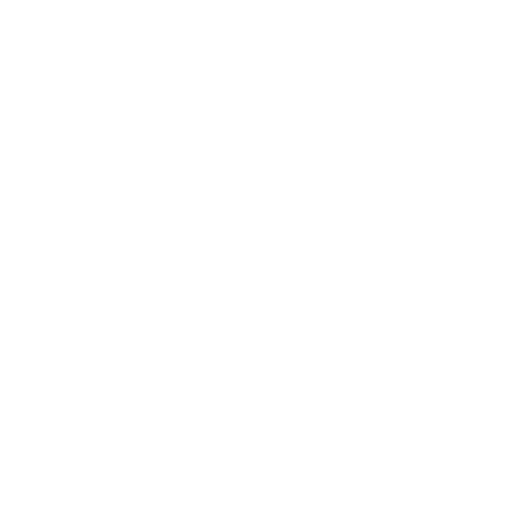

In [176]:
img = Image.new(mode='1', size=(width, height), color=1)
img \
    .resize((width * display_scale_factor, height * display_scale_factor), resample=None)

Закрашивание рядов

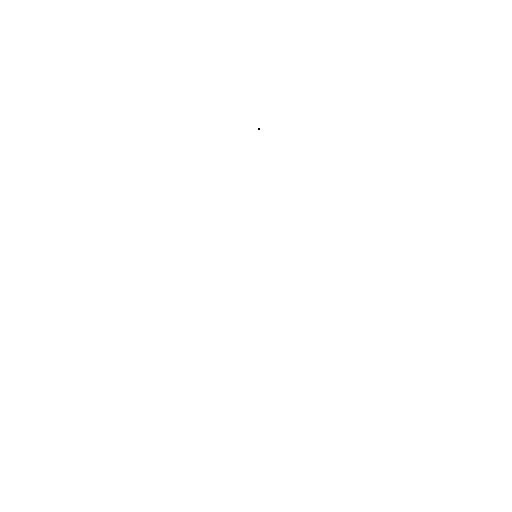

In [177]:
def colorize_row_in_place(image: Image.Image, row: np.ndarray, row_idx: int, invert: bool = True) -> Image.Image:
    """Works in place"""
    # Ensure the row is a 1D NumPy array
    row = row.flatten()

    # Invert the row if specified
    if invert:
        row = 1 - row

    # Create a new 1-bit image for the row
    row_img = Image.fromarray(row.reshape((1, row.shape[0])).astype(np.uint8) * 255, mode='L').convert('1')

    # Paste the row image into the specified row index
    image.paste(row_img, (0, row_idx))

    return image


def copy_with_colorized_row(image: Image.Image, row: np.ndarray, row_idx: int, invert: bool = True) -> Image.Image:
    new_img = image.copy()
    colorize_row_in_place(new_img, row, row_idx, invert)
    return new_img


new_row = np.zeros(width, dtype=np.uint8)
new_row[colored_pixel_indices] = 1

copy_with_colorized_row(img, new_row, 64) \
    .resize((width * display_scale_factor, height * display_scale_factor), resample=None)

Функции для генерации следующих шагов моделирования

In [178]:
def generate_next_row(current_row: np.ndarray, rule: Callable[[list[bool]], bool]) -> np.ndarray:
    next_row = np.zeros(shape=current_row.shape, dtype=np.uint8)
    row_len = current_row.shape[0]
    for i in range(row_len):
        next_row[i] = rule([
            current_row[i - 1] if i > 0 else 0,
            current_row[i],
            current_row[i + 1] if i < row_len - 1 else 0
        ])
    return next_row

def generate_next_row_vec(current_row: np.ndarray, rule: Callable[[np.ndarray], np.ndarray]) -> np.ndarray:
    # Pad the current row to handle edge cases
    padded_row = np.pad(current_row, (1, 1), mode='constant', constant_values=0)
    
    # Extract left, center, and right neighbors
    left = padded_row[:-2]
    center = padded_row[1:-1]
    right = padded_row[2:]
    
    # Stack neighbors into a 2D array
    neighbors = np.stack((left, center, right), axis=1)
    
    # Apply the rule function to each set of neighbors
    return rule(neighbors)

Симуляция и визуализация

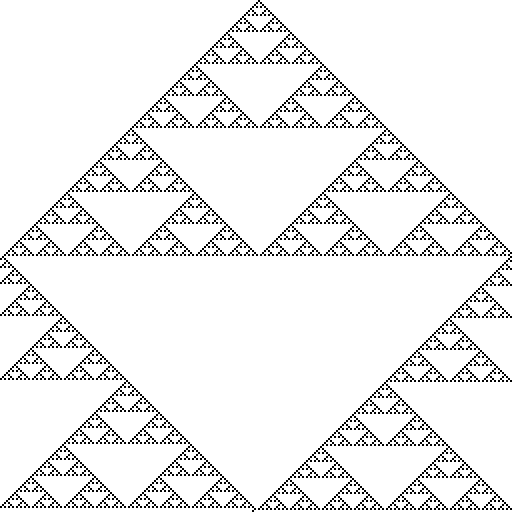

In [179]:
initial_row = np.zeros(width, dtype=np.uint8)
initial_row[colored_pixel_indices] = 1

current_row = initial_row.copy()
previous_row = initial_row.copy()

for i in range(height):
    colorize_row_in_place(img, current_row, i)
    # previous_row, current_row = current_row, generate_next_row(current_row, next_state_fn)
    previous_row, current_row = current_row, generate_next_row_vec(current_row, next_state_fn_vec)
    
img \
    .resize((width * display_scale_factor, height * display_scale_factor), resample=None)

Обобщение в виде функции

In [180]:
def generate_ca(
    width: int,
    height: int,
    colored_pixel_indices: list[int],
    wolfram_code: int = 90,
    display_scale: int = 2,
) -> Image.Image:
    """
    Generate a 1D cellular automaton image using a given Wolfram rule.
    
    :param width: Number of pixels per row
    :param height: Number of rows (generations)
    :param colored_pixel_indices: Indices in the first row to activate (set to 1)
    :param wolfram_code: Integer Wolfram rule (0–255), default = 90
    :param display_scale: Scale factor for display resizing
    :return: PIL.Image in mode '1'
    """
    
    img = Image.new(mode='1', size=(width, height), color=1)
    
    # Create and initialize the first row
    current_row = np.zeros(width, dtype=np.uint8)
    current_row[colored_pixel_indices] = 1
    
    next_state_fn_vec = bool_func_from_wolfram_code_vec(wolfram_code)
    
    for i in range(height):
        colorize_row_in_place(img, current_row, i)
        previous_row, current_row = current_row, generate_next_row_vec(current_row, next_state_fn_vec)
    
    if display_scale_factor != 1:
        return img.resize((width * display_scale, height * display_scale), resample=None)
    return img

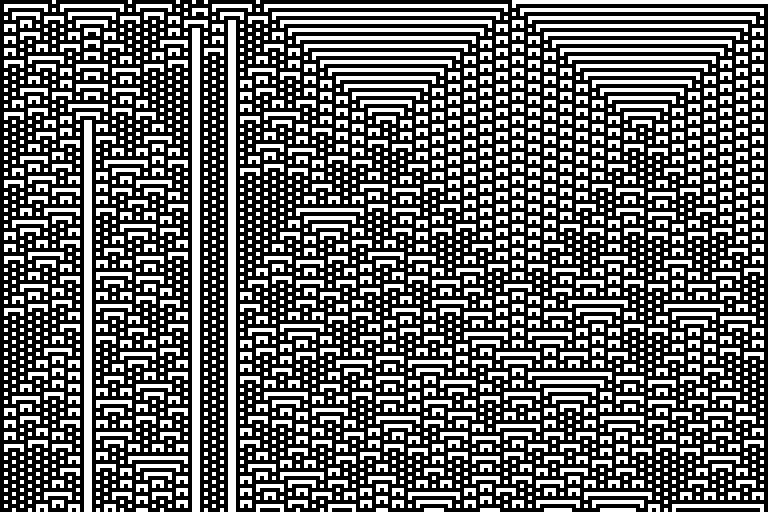

In [184]:
generate_ca(
    width = 192,
    height = 128,
    colored_pixel_indices = [i for i in range(128) if random.random() < .95],
    wolfram_code = 109,
    display_scale = 4
)